In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from ocpaper231.plotutils import Plot
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
from torch_geometric.utils import index_to_mask
from torch_geometric.data import Data
import scienceplots
from gnn_tracking.utils.loading import TrackingDataModule
import numpy as np


plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from ocpaper231.names import variable_manager as vm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import importlib
import gnn_tracking.metrics.cluster_metrics

importlib.reload(gnn_tracking.metrics.cluster_metrics)

<module 'gnn_tracking.metrics.cluster_metrics' from '/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/metrics/cluster_metrics.py'>

In [34]:
dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_9/"
        ],
        stop=10,
    ),
)
dm.setup(stage="fit")

[17:56:03] INFO: DataLoader will load 900 graphs (out of 900 available).
[17:56:03] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_1/data21999_s0.pt
[17:56:03] INFO: DataLoader will load 10 graphs (out of 1000 available).
[17:56:03] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_9/data29009_s0.pt


In [35]:
from gnn_tracking.utils.lightning import find_latest_checkpoint
from pathlib import Path


model = "discerning-unbiased-sponge"
chkpt_path = find_latest_checkpoint(
    Path(
        f"/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/"
    ),
    model,
)

In [36]:
chkpt_path

PosixPath('/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/discerning-unbiased-sponge/checkpoints/epoch=88-step=640800.ckpt')

In [37]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location="cpu")

[17:56:06] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[17:56:06] DEBUG: Getting class PotentialLoss from module gnn_tracking.metrics.losses
[17:56:06] DEBUG: Getting class BackgroundLoss from module gnn_tracking.metrics.losses
[17:56:06] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


# VS EPS

In [38]:
eps = np.linspace(0.001, 1, 80)
ks = [1]  # np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

eps_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)
lmodel.cluster_scanner = eps_scanner

In [39]:
ModelSummary(lmodel)

  | Name            | Type                 | Params
---------------------------------------------------------
0 | model           | PreTrainedECGraphTCN | 1.9 M 
1 | potential_loss  | PotentialLoss        | 0     
2 | background_loss | BackgroundLoss       | 0     
---------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.579     Total estimated model params size (MB)

In [40]:
trainer = Trainer(accelerator="cpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[17:56:09] INFO: DataLoader will load 10 graphs (out of 1000 available).
[17:56:09] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_9/data29009_s0.pt
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


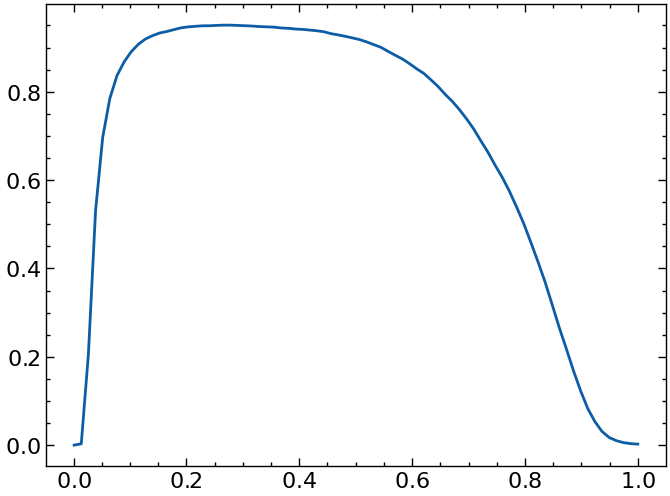

In [42]:
plt.plot("eps", "double_majority_pt0.9", data=eps_scanner.get_results().df_mean)

In [43]:
df = eps_scanner.get_results().df_mean
dm_max_idx = df["double_majority_pt0.9"].argmax()
dm_max_thld = df.loc[dm_max_idx, "eps"]

In [44]:
dm_max_thld

0.2665569620253165

In [28]:
eps_scanner.get_results().df_mean

,eps,min_samples,i_batch,n_particles,n_cleaned_clusters,perfect,double_majority,lhc,fake_perfect,fake_double_majority,...,fake_double_majority_pt0.9_std,fake_lhc_pt0.9_std,n_particles_pt1.5_std,n_cleaned_clusters_pt1.5_std,perfect_pt1.5_std,double_majority_pt1.5_std,lhc_pt1.5_std,fake_perfect_pt1.5_std,fake_double_majority_pt1.5_std,fake_lhc_pt1.5_std
0,0.001000,1,0.0,7821.0,1.0,0.000000,0.000000,0.000000,0.000128,0.000128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.013646,1,0.0,7821.0,539.0,0.000000,0.000895,0.992579,0.068917,0.068022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.026291,1,0.0,7821.0,1066.0,0.005370,0.051144,0.984991,0.130930,0.085155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.038937,1,0.0,7821.0,1598.0,0.045391,0.141158,0.978098,0.158931,0.063163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.051582,1,0.0,7821.0,1913.0,0.092443,0.185143,0.976477,0.152154,0.059455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.949418,1,0.0,7821.0,388.0,0.012530,0.021608,0.708763,0.037080,0.028002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,0.962063,1,0.0,7821.0,276.0,0.009462,0.015599,0.757246,0.025828,0.019691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,0.974709,1,0.0,7821.0,197.0,0.007160,0.010996,0.786802,0.018028,0.014193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,0.987354,1,0.0,7821.0,158.0,0.005114,0.008055,0.803797,0.015088,0.012147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



# vs pt and eta


## Actual performance

In [45]:
# eyeballed
best_eps = dm_max_thld
best_k = 1

In [46]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

detail_scanner = DBSCANPerformanceDetails(eps=best_eps, min_samples=best_k)
lmodel.cluster_scanner = detail_scanner

trainer = Trainer(accelerator="cpu")
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[18:00:35] INFO: DataLoader will load 10 graphs (out of 1000 available).
[18:00:35] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6_cut/part_

Validation: 0it [00:00, ?it/s]

In [48]:
h_dfs, c_dfs = detail_scanner.get_results()

In [25]:
import pickle

with Path("h_dfs.pkl").open("wb") as f:
    pickle.dump(h_dfs, f)
with Path("c_dfs.pkl").open("wb") as f:
    pickle.dump(c_dfs, f)

In [49]:
etas = np.array(np.linspace(-4, 4, 8 * 2 + 1).tolist() + [4.0])
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

In [65]:
etas.shape

(21,)

In [53]:
vs_eta_uul = pd.read_csv(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/vs_eta_gc.csv"
)

In [51]:
# vs_eta_cc = pd.read_csv("/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/vs_eta_cc.csv")

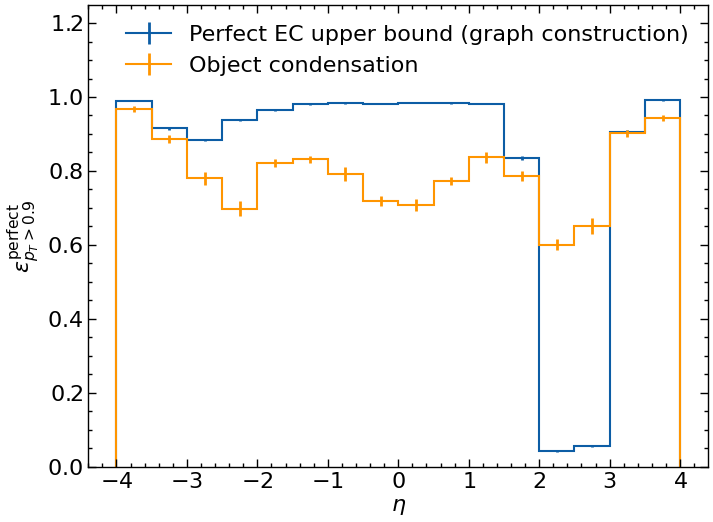

In [73]:
from gnn_tracking.analysis.efficicies import PerformanceComparisonPlot

p = PerformanceComparisonPlot(
    xs=etas, var="perfect", x_label=vm["eta"].latex, ylabel=vm["perfect_pt0.9"].latex
)
p.ax.set_ylim(0.0, 1.25)
p.plot_var(vs_eta_uul, label="Perfect EC upper bound (graph construction)", color="C0")
# p.plot_var(vs_eta_ul, label="Perfect EC upper bound (EF)", color="C1")
p.plot_var(vs_eta, label="Object condensation", color="C2")
# p.plot_var(vs_eta_cc, label="Connected components (EF)", color="C3")
p.add_legend()
p.ax.get_figure().savefig("vs_eta_dm_broken_graphs.pdf")